# Basic experiment

# Make toy data

## Type 1. Independent Gaussian

$$
(x_1, x_2) \sim \mathcal{N}(0,I)
$$

## Type 2. Correlated Gaussian

$$
(y_1, y_2) \sim \mathcal{N}(0,\begin{bmatrix}1&\rho\\ \rho&1\end{bmatrix})
$$

In [28]:
import numpy as np
from time import time

In [2]:
x = np.random.multivariate_normal( mean=[0,0],
                                  cov=[[1,0],[0,1]],
                                 size = 300)

In [3]:
y = np.random.multivariate_normal( mean=[0,0],
                                  cov=[[1,0.8],[0.8,1]],
                                 size = 300)

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

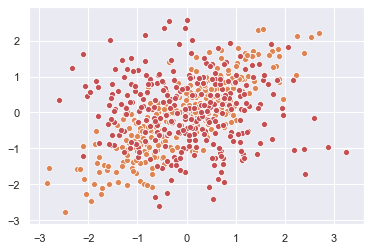

In [8]:
# plt indep Gaussian
sns.scatterplot(x=x[:,0],y=x[:,1])
plt.show()

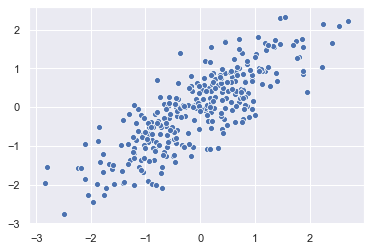

In [9]:
# plt cor Gaussian
sns.scatterplot(x=y[:,0],y=y[:,1])
plt.show()

# Define MINE

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd

In [11]:
class Mine(nn.Module):
    def __init__(self, input_size=2, hidden_size=100):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        nn.init.normal_(self.fc1.weight,std=0.02)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight,std=0.02)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight,std=0.02)
        nn.init.constant_(self.fc3.bias, 0)
        
    def forward(self, input):
        output = F.elu(self.fc1(input))
        output = F.elu(self.fc2(output))
        output = self.fc3(output)
        return output

In [12]:
def mutual_information(joint, marginal, mine_net):
    t = mine_net(joint)
    et = torch.exp(mine_net(marginal))
    mi_lb = torch.mean(t) - torch.log(torch.mean(et))
    return mi_lb, t, et

def learn_mine(batch, mine_net, mine_net_optim,  ma_et, ma_rate=0.01):
    # batch is a tuple of (joint, marginal)
    joint , marginal = batch
    joint = torch.autograd.Variable(torch.FloatTensor(joint)).cuda()
    marginal = torch.autograd.Variable(torch.FloatTensor(marginal)).cuda()
    mi_lb , t, et = mutual_information(joint, marginal, mine_net)
    ma_et = (1-ma_rate)*ma_et + ma_rate*torch.mean(et)
    
    # unbiasing use moving average
    loss = -(torch.mean(t) - (1/ma_et.mean()).detach()*torch.mean(et))
    # use biased estimator
#     loss = - mi_lb
    
    mine_net_optim.zero_grad()
    autograd.backward(loss)
    mine_net_optim.step()
    return mi_lb, ma_et

In [13]:
def sample_batch(data, batch_size=100, sample_mode='joint'):
    if sample_mode == 'joint':
        index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        batch = data[index]
    else:
        joint_index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        marginal_index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        batch = np.concatenate([data[joint_index][:,0].reshape(-1,1),
                                         data[marginal_index][:,1].reshape(-1,1)],
                                       axis=1)
    return batch

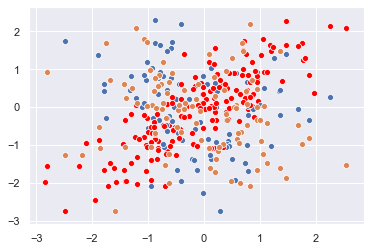

In [15]:
joint_data = sample_batch(y,batch_size=100,sample_mode='joint')
sns.scatterplot(x=joint_data[:,0],y=joint_data[:,1],color='red')
marginal_data = sample_batch(y,batch_size=100,sample_mode='marginal')
sns.scatterplot(x=marginal_data[:,0],y=marginal_data[:,1])
plt.show()

In [33]:
def train(data, mine_net,mine_net_optim, batch_size=100, iter_num=int(5e+4), log_freq=int(1e+3)):
    # data is x or y
    result = list()
    ma_et = 1.
    for i in range(iter_num):
        batch = sample_batch(data,batch_size=batch_size)\
        , sample_batch(data,batch_size=batch_size,sample_mode='marginal')
        mi_lb, ma_et = learn_mine(batch, mine_net, mine_net_optim, ma_et)
        result.append(mi_lb.detach().cpu().numpy())
        if (i+1)%(log_freq)==0:
            print(result[-1])
    return result

In [17]:
def ma(a, window_size=100):
    return [np.mean(a[i:i+window_size]) for i in range(0,len(a)-window_size)]

In [18]:
mine_net_indep = Mine().cuda()
mine_net_optim_indep = optim.Adam(mine_net_indep.parameters(), lr=1e-3)
result_indep = train(x,mine_net_indep,mine_net_optim_indep)

-0.00067276024
6.708117e-05
2.1528127e-05
0.00045344146
5.47542e-05


-1.4392128e-05


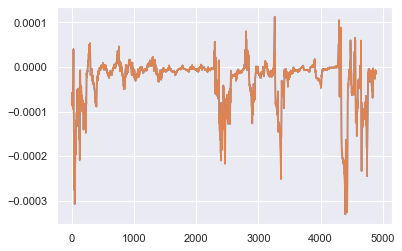

In [20]:
result_indep_ma = ma(result_indep)
print(result_indep_ma[-1])
plt.plot(range(len(result_indep_ma)),result_indep_ma)
plt.show()

In [21]:
mine_net_cor = Mine().cuda()
mine_net_optim_cor = optim.Adam(mine_net_cor.parameters(), lr=1e-3)
result_cor = train(y,mine_net_cor,mine_net_optim_cor)

0.7313678
0.65131736
0.6074187
0.5331747
0.66498816


0.5724046


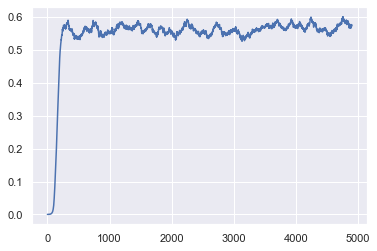

In [22]:
result_cor_ma = ma(result_cor)
print(result_cor_ma[-1])
plt.plot(range(len(result_cor_ma)),result_cor_ma)
plt.show()

# Test with various correlations

In [23]:
correlations = np.linspace(-0.9,0.9,19)
print(correlations)

[-0.9 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4
  0.5  0.6  0.7  0.8  0.9]


In [44]:
final_result = []
for rho in correlations:
    rho_data = np.random.multivariate_normal(mean=[0,0],
                                  cov=[[1,rho],[rho,1]],
                                     size=10**3)
    start = time()
    mine_net = Mine().cuda()
    mine_net_optim = optim.Adam(mine_net.parameters(), lr=1e-3)
    result = train(rho_data,mine_net,mine_net_optim,iter_num=10**4,batch_size=50,log_freq=int(1e+5))
    result_ma = ma(result)
    final_result.append(result_ma[-1])
    theoretical = -0.5*np.log(1-rho**2)
    print('rho = ' + str(rho) + ' : MI = ' + str(final_result[-1]) + 
          ' : theoretical = ' + str(np.float32(theoretical)) + 
          ' : time = ' + str(np.round((time()-start)/60,2)) + " min")
    plt.plot(range(len(result_ma)),result_ma)

rho = -0.9 : MI = 0.8831228 : theoretical = 0.8303656 : time = 0.32 min
rho = -0.8 : MI = 0.55843866 : theoretical = 0.51082563 : time = 0.32 min
rho = -0.7 : MI = 0.358096 : theoretical = 0.33667228 : time = 0.32 min
rho = -0.6 : MI = 0.24995464 : theoretical = 0.22314355 : time = 0.31 min
rho = -0.5 : MI = 0.13289249 : theoretical = 0.14384104 : time = 0.31 min
rho = -0.4 : MI = 0.07801272 : theoretical = 0.087176695 : time = 0.31 min
rho = -0.29999999999999993 : MI = 0.04667056 : theoretical = 0.04715534 : time = 0.31 min
rho = -0.19999999999999996 : MI = 0.0067684692 : theoretical = 0.020410998 : time = 0.32 min
rho = -0.09999999999999998 : MI = -1.5414636e-05 : theoretical = 0.005025168 : time = 0.32 min
rho = 0.0 : MI = -1.4788346e-05 : theoretical = -0.0 : time = 0.31 min
rho = 0.09999999999999998 : MI = -2.3544446e-06 : theoretical = 0.005025168 : time = 0.32 min
rho = 0.20000000000000007 : MI = 0.016410451 : theoretical = 0.020410998 : time = 0.31 min
rho = 0.30000000000000016

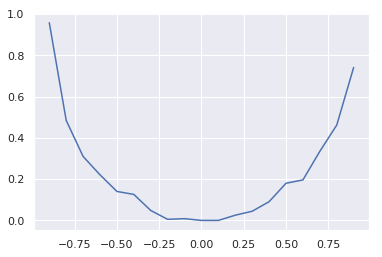

In [20]:
plt.plot(correlations, final_result)

# Equitability experiment

Check more information at [original equitability paper](http://www.pnas.org/content/pnas/111/9/3354.full.pdf).

# Make toy data

In [21]:
x = np.random.uniform(low=-1.,high=1.,size=3000)
f1 = x
f2 = 2*x
f3 = np.sin(x)
f4 = x**3
eps = np.random.normal(size=3000)

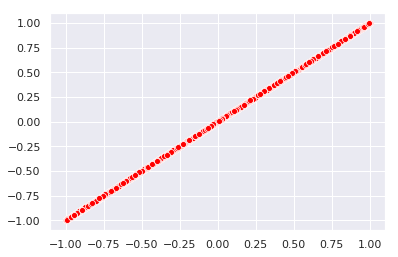

In [22]:
sns.scatterplot(x, f1,color='red')

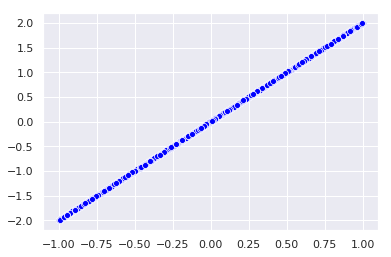

In [23]:
sns.scatterplot(x, f2,color='blue')

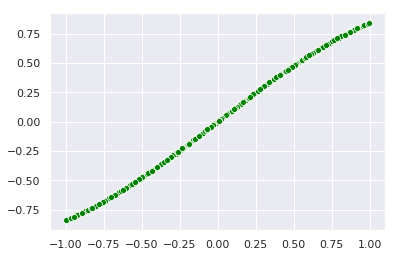

In [24]:
sns.scatterplot(x, f3,color='green')

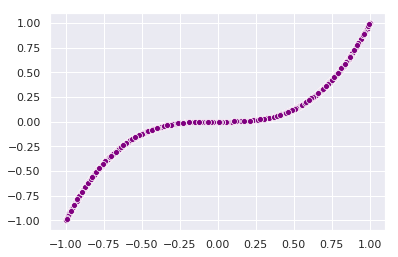

In [25]:
sns.scatterplot(x, f4,color='purple')

In [26]:
sigmas = np.linspace(0.0,0.9,10)
fs = [f1, f2, f3, f4]
print(sigmas)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


4.3165164
4.428666
4.693854
11.412927
5.0883727
0.0,0 : 5.773359
3.4128466
3.8177392
4.4555326
4.4452915
3.489471
0.0,1 : 5.864722
2.55121
2.4870567
3.3649533
2.5808315
3.5454357
0.0,2 : 3.0371892
1.0605474
1.0484655
1.8002052
1.7783278
2.7316294
0.0,3 : 1.8558613
1.6044647
1.7972416
1.6301302
1.2586992
1.9363227
0.1,0 : 1.6577556
2.5292113
3.4724848
2.9540653
2.444877
2.1020966
0.1,1 : 2.363647
1.2385798
1.5869575
1.392125
1.4103067
1.3495559
0.1,2 : 1.5508937
1.137523
0.7532096
0.82436013
0.9533508
1.2207271
0.1,3 : 1.0978585
0.9161378
0.93390846
0.85513234
0.88875747
0.9204679
0.2,0 : 1.0572222
1.4972677
1.6500105
1.563633
2.1706228
1.9646666
0.2,1 : 1.6792473
0.9622601
0.7099171
0.88597417
0.9166153
0.9260552
0.2,2 : 0.97315335
0.21291333
0.5130028
0.7539356
0.45293054
0.72957635
0.2,3 : 0.5490277
0.7204771
0.7493786
0.85244
0.74890107
0.9470168
0.30000000000000004,0 : 0.74223465
1.3280952
0.85781586
1.6996737
1.5334388
1.4874064
0.30000000000000004,1 : 1.3006543
0.56149685
0.79391

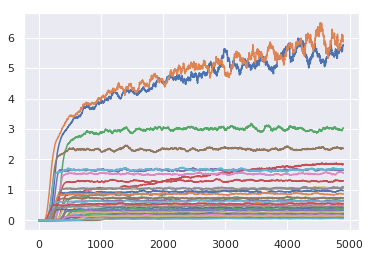

In [27]:
final_result = []
for sigma in sigmas:
    for fi, f in enumerate(fs):
        data = np.concatenate([x.reshape(-1,1), (f + sigma * eps).reshape(-1,1)], axis=1)
        mine_net = Mine().cuda()
        mine_net_optim = optim.Adam(mine_net.parameters(), lr=1e-3)
        result = train(data,mine_net,mine_net_optim,iter_num=int(5e+3))
        result_ma = ma(result)
        final_result.append(result_ma[-1])
        print(str(sigma) + ',' + str(fi) +' : ' + str(final_result[-1]))
        plt.plot(range(len(result_ma)),result_ma)

In [28]:
re_final_result = np.transpose(np.array([final_result[4*i: 4*i+4]  for i in range(10)]))
print(re_final_result)

[[5.773359   1.6577556  1.0572222  0.74223465 0.5394236  0.41392532
  0.324629   0.2505124  0.19948366 0.15108423]
 [5.864722   2.363647   1.6792473  1.3006543  1.0629547  0.87138265
  0.7165672  0.6171741  0.5421426  0.46416825]
 [3.0371892  1.5508937  0.97315335 0.6528235  0.49730837 0.37166065
  0.27176207 0.22408777 0.16892713 0.15220916]
 [1.8558613  1.0978585  0.5490277  0.3773468  0.2407205  0.18949112
  0.14217764 0.10066611 0.08995808 0.06090287]]


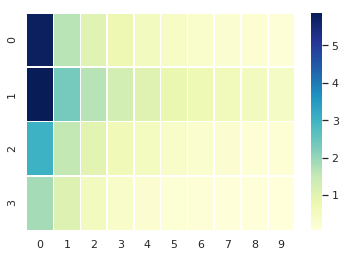

In [29]:
sns.heatmap(re_final_result,cmap="YlGnBu",linewidths=.5)